# POS Tagging and Chunking Example with Web Scraping

## Tagging

### Imports & Preparation

In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
import re
import requests
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
# REQUIRES 'contractions.py' in your root folder
from contractions import CONTRACTION_MAP

nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

### Scrape Dataset

In [3]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

#you can adjust this function to scrape other websites.
def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        articles = [{'headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'category': category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['headline', 'article', 'category']]
    return df

In [4]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,headline,article,category
0,Girl shows up for interview with Microsoft a m...,An exchange between 21-year-old Scottish stude...,technology
1,It’s hard to beat this: Bill Gates shares 'Wor...,Microsoft Co-founder and the world's second-ri...,technology
2,Apple AirPods may get 'Hey Siri' command suppo...,"Apple's next generation AirPods, which are rum...",technology
3,"35 yrs ago, it said hello: Tim Cook on Apple's...",Apple CEO Tim Cook on Thursday recalled the da...,technology
4,"Zuckerberg plans to integrate WhatsApp, Instag...",Facebook CEO Mark Zuckerberg plans to integrat...,technology
5,Tinder agrees to settle $23 million age discri...,Tinder has settled a $23-million California cl...,technology
6,We don't sell people's data: Facebook CEO Mark...,"Facebook CEO Mark Zuckerberg has said that ""we...",technology
7,"Zuckerberg once killed a goat, served it to me...",Twitter CEO Jack Dorsey revealed that Facebook...,technology
8,"Man asks for new Maps feature, Google India re...","Google India has responded to a viral tweet, w...",technology
9,Apple fires 200 employees working on self-driv...,Apple has fired 200 employees working for its ...,technology


In [5]:
news_df.category.value_counts()

technology    25
world         25
sports        25
Name: category, dtype: int64

### Dataset Pre-Processing/Cleaning

In [6]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)

In [7]:
# combining headline and article text
news_df['full_text'] = news_df["headline"].map(str)+ '. ' + news_df["article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': "It’s hard to beat this: Bill Gates shares 'World's 10 Year Challenge'. Microsoft Co-founder and the world's second-richest person Bill Gates on Saturday shared the 'World's 10 Year Challenge' showing the human progress in life expectancy, youth literacy, child mortality and reducing extreme poverty. The graphic shared by Gates is originally created by Johan Norberg, a senior fellow at think tank Cato Institute and author of several books about economics and globalisation.",
 'clean_text': None}

### Export to CSV (OPTIONAL)

In [8]:
# Everything works great? Run this to save our new dataset
news_df.to_csv('news_inshorts.csv', index=False, encoding='utf-8')

### Generate Cleaned Corpus

In [9]:
# generate a basic pre-processed corpus
# DO NOT lowercase in order to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# select a single headline for demonstration
sentence = str(news_df.iloc[1].headline)
sentence2 = str(news_df.iloc[2].headline)
sentence3 = str(news_df.iloc[3].headline)
sentence4 = str(news_df.iloc[4].headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
spacy_df = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
nltk_pos_tagged2 = nltk.pos_tag(sentence2.split())
nltk_pos_tagged3 = nltk.pos_tag(sentence3.split())
nltk_pos_tagged4 = nltk.pos_tag(sentence4.split())

nltk_df = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

spacy_df
#nltk_df

,Word,POS tag,Tag type
0,It,PRP,PRON
1,’s,VBZ,VERB
2,hard,JJ,ADJ
3,to,TO,PART
4,beat,VB,VERB
5,this,DT,DET
6,:,:,PUNCT
7,Bill,NNP,PROPN
8,Gates,NNP,PROPN
9,shares,NNS,NOUN


## Chunking

### Prepare Data

In [10]:
# Use this if you do not have the corpus already
# nltk.download('conll2000')

# Import conll2000
from nltk.corpus import conll2000

# Prep train/test data
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [11]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [12]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [13]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# Define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# Train model  
ntc = NGramTagChunker(train_data)
chunk_tree = ntc.parse(nltk_pos_tagged)
chunk_tree2 = ntc.parse(nltk_pos_tagged2)
chunk_tree3 = ntc.parse(nltk_pos_tagged3)
chunk_tree4 = ntc.parse(nltk_pos_tagged4)

# Evaluate model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


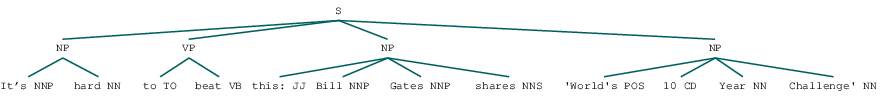

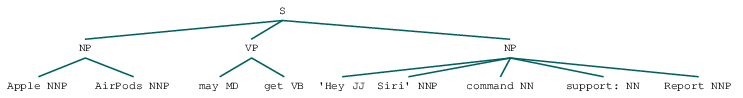

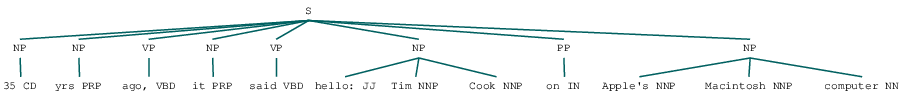

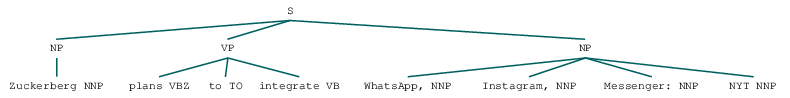

In [14]:
from IPython.display import display

## download and install ghostscript from 
## https://www.ghostscript.com/download/gsdnld.html

# often need to add to the path manually 
# (for windows, via environment variables > system > 'Path' or 'PATH')

display(chunk_tree)
display(chunk_tree2)
display(chunk_tree3)
display(chunk_tree4)

In [16]:
spacy_df
# nltk_df

,Word,POS tag,Tag type
0,It,PRP,PRON
1,’s,VBZ,VERB
2,hard,JJ,ADJ
3,to,TO,PART
4,beat,VB,VERB
5,this,DT,DET
6,:,:,PUNCT
7,Bill,NNP,PROPN
8,Gates,NNP,PROPN
9,shares,NNS,NOUN
